In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2_1BEST_RANDOM')

test500 = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'ricseq500.csv'))
intarna = pd.read_csv(os.path.join(intarna_dir, f'ricseq500_RANDOM', f'ricseq.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

intarna = intarna.dropna()

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

res = pd.read_csv(os.path.join(checkpoint_dir, f'ricseq_results500.csv'))
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

res_ricseq = res.copy()

In [4]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'RANDOM', f'test500.csv'))
res = pd.read_csv(os.path.join(checkpoint_dir, f'test_results500.csv'))
intarna = pd.read_csv(os.path.join(intarna_dir, f'RANDOM', f'test500', f'test.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

intarna = intarna.dropna()

res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

res_paris = res.copy()

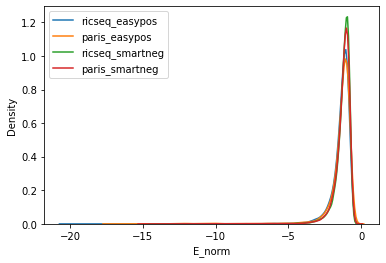

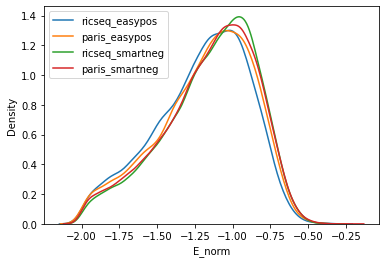

In [5]:
treshold_plot = -2
sns.kdeplot(res_ricseq[res_ricseq.policy == 'easypos'].E_norm, label = 'ricseq_easypos')
sns.kdeplot(res_paris[res_paris.policy == 'easypos'].E_norm, label = 'paris_easypos')
sns.kdeplot(res_ricseq[res_ricseq.policy == 'smartneg'].E_norm, label = 'ricseq_smartneg')
sns.kdeplot(res_paris[res_paris.policy == 'smartneg'].E_norm, label = 'paris_smartneg')

plt.legend()
plt.show()

sns.kdeplot(res_ricseq[(res_ricseq.policy == 'easypos')&(res_ricseq.E_norm>treshold_plot)].E_norm, label = 'ricseq_easypos')
sns.kdeplot(res_paris[(res_paris.policy == 'easypos')&(res_paris.E_norm>treshold_plot)].E_norm, label = 'paris_easypos')
sns.kdeplot(res_ricseq[(res_ricseq.policy == 'smartneg')&(res_ricseq.E_norm>treshold_plot)].E_norm, label = 'ricseq_smartneg')
sns.kdeplot(res_paris[(res_paris.policy == 'smartneg')&(res_paris.E_norm>treshold_plot)].E_norm, label = 'paris_smartneg')
plt.legend()
plt.show()



In [8]:
# HQ
treshold = 25
subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
res = res[res.id_sample.isin(subset.couples)]
res_paris = res.copy()

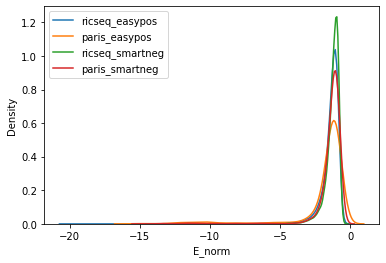

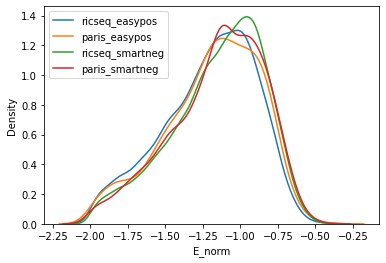

In [13]:
treshold_plot = -2
sns.kdeplot(res_ricseq[res_ricseq.policy == 'easypos'].E_norm, label = 'ricseq_easypos')
sns.kdeplot(res_paris[res_paris.policy == 'easypos'].E_norm, label = 'paris_easypos')
sns.kdeplot(res_ricseq[res_ricseq.policy == 'smartneg'].E_norm, label = 'ricseq_smartneg')
sns.kdeplot(res_paris[res_paris.policy == 'smartneg'].E_norm, label = 'paris_smartneg')

plt.legend()
plt.show()

sns.kdeplot(res_ricseq[(res_ricseq.policy == 'easypos')&(res_ricseq.E_norm>treshold_plot)].E_norm, label = 'ricseq_easypos')
sns.kdeplot(res_paris[(res_paris.policy == 'easypos')&(res_paris.E_norm>treshold_plot)].E_norm, label = 'paris_easypos')
sns.kdeplot(res_ricseq[(res_ricseq.policy == 'smartneg')&(res_ricseq.E_norm>treshold_plot)].E_norm, label = 'ricseq_smartneg')
sns.kdeplot(res_paris[(res_paris.policy == 'smartneg')&(res_paris.E_norm>treshold_plot)].E_norm, label = 'paris_smartneg')
plt.legend()
plt.show()